<a href="https://colab.research.google.com/github/BautistaDavid/DavidBautista_Blog/blob/main/blog/python_fundamentals/OLS_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stata? I Only Know Python

The idea of this class is to mimic the typical output of a Stata least squares regression.Below you can see an example of the output of a regression of this type in Stata using the "crime1" database from the Wooldrige Econometrics book.

Excuting the comand ```reg inc86 pcnv avgsen tottime``` the output is: 



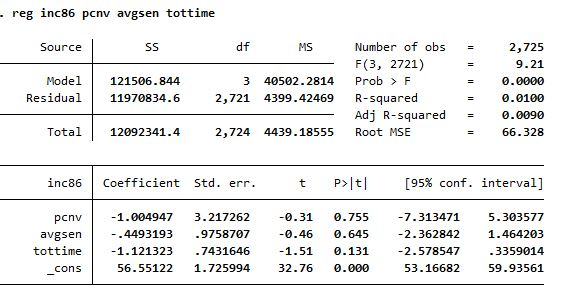



As I mentioned before, the idea is to create a class that allows us to replicate Stata output in python. So let's do it!

In [15]:
# We have to import some modules to use matrix and calculate statistics
import numpy as np 
import pandas as pd 
import scipy.stats as sst
from scipy import stats

class Lineal_Reg(object):
  def __init__(self,Y,X,alpha=0.05,intercepto = True):
    self.intercepto = intercepto
    self.Y = Y.to_numpy().reshape(len(Y),1)
    if self.intercepto == True: 
      self.X = np.c_[np.ones(self.Y.shape[0]),X.to_numpy()] if len(X.shape) !=1 else np.c_[np.ones(len(X)),X.to_numpy().reshape([len(X),1])]     
    elif self.intercepto == False: 
      self.X = X.to_numpy() if len(X.shape) !=1 else X.to_numpy().reshape([len(X),1])

    self.alpha = alpha
    self.names = X.columns if len(X.shape)!=1 else [X.name]
    self.n = self.X.shape[0]
    self.k = self.X.shape[1] -1 if len(X.shape) !=1 else 1
    self.gl = self.n - self.k -1
  
  class fit():
    def __init__(self):
      Lineal_Reg.__init__(self,Y,X,alpha=0.05,intercepto = True)
      self.betas = (np.linalg.inv(self.X.T@self.X)@self.X.T@self.Y)
  
    def __anova(self):
      self.residuos = self.Y - (self.X @ self.betas)
      self.SEC = np.sum(np.square(self.X @ self.betas -np.mean(self.Y)))
      self.SRC = np.sum(np.square(self.residuos))
      self.STC = np.sum(np.square(self.Y-np.mean(self.Y)))
      self.R_2 = 1-self.SRC/self.STC
      self.estadistico_F = (self.R_2 / self.k) / ((1-self.R_2)/(self.n - self.k -1))
      self.MS_model = self.SEC / self.k    #desviaciones media 
      self.MS_residual = self.SRC / self.gl 
      self.MS_total = self.STC / (self.n - 1)

    def __tabla_resultados(self):
      self.m_covarianzas = (self.SRC/self.gl) * (np.linalg.inv(self.X.T @ self.X))
      self.varianzas = np.diag(self.m_covarianzas)
      self.errores_estandar = np.sqrt(self.varianzas).ravel().tolist() # ya quedo en lista
      self.t_values = [betas/errores for (betas,errores) in zip(self.betas.ravel().tolist(),self.errores_estandar)]
      self.p_values = [stats.t.sf(np.abs(t_val), self.n-1)*2 for t_val in self.t_values]  #t,Gl
    #intervalos 
      self.t_level = sst.t.ppf(1 - self.alpha/2, df=self.n - self.k - 1 )  # df = n-k-1
      self.intervalos = [sorted([beta - (errcoef * self.t_level),beta + (errcoef * self.t_level)]) for (beta,errcoef) in zip(self.betas.ravel().tolist(),self.errores_estandar)]
  
    @property 
    def summary(self):
      self.__anova()
      self.__tabla_resultados()
      panel = pd.DataFrame(index=["Modelo","Residual","Total"])
      panel["SS"] = [round(i,2) for i in [self.SEC,self.SRC,self.STC]]
      panel["df"] = [self.k,self.gl,self.n-1]
      panel["MS"] = [round(i,2) for i in [self.MS_model,self.MS_residual,self.MS_total]]
      panel["  "] = ["   ","   ","   "]
      panel["    "] = [f"No. Observaciones = {self.n}",f"F{self.k,self.gl} = {round(self.estadistico_F,2)}",f"R-cuadrado = {round(self.R_2,4)}"]   # Esto toca organizarlo mejor  
   
      resultados=pd.DataFrame(index= ["_Cons"]+ [i for i in self.names]) if self.intercepto == True else pd.DataFrame(index= [i for i in self.__names])
      resultados["Coeficientes"] = [round(i,3) for i in self.betas.ravel().tolist()]
      resultados["E.Estandar"] = self.errores_estandar
      resultados["t"] = [round(i,2) for i in self.t_values]
      resultados["P"] = [round(i,4) for i in self.p_values] 
      resultados["Intervalos de confianza"] = [(round(i[0],6),round(i[1],6)) for i in self.intervalos]
      print(panel)
      print()
      print(resultados)

In [16]:
# !pip install wooldridge
import wooldridge as wd 
datos_crimen = wd.data("crime1")

Y = datos_crimen["inc86"]
X = datos_crimen[['pcnv','avgsen','tottime']]
modelo = Lineal_Reg(Y,X,alpha=0.05)
reg = modelo.fit()
reg.summary

                   SS    df        MS                               
Modelo      121506.84     3  40502.28       No. Observaciones = 2725
Residual  11970834.58  2721   4399.42              F(3, 2721) = 9.21
Total     12092341.43  2724   4439.19              R-cuadrado = 0.01

         Coeficientes  E.Estandar      t       P Intervalos de confianza
_Cons          56.551    1.725994  32.76  0.0000  (53.166824, 59.935609)
pcnv           -1.005    3.217262  -0.31  0.7548   (-7.313471, 5.303577)
avgsen         -0.449    0.975871  -0.46  0.6452   (-2.362842, 1.464203)
tottime        -1.121    0.743165  -1.51  0.1315   (-2.578547, 0.335901)
